In [33]:
!nvidia-smi

Fri Mar 14 00:31:02 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA A100-SXM4-40GB          Off |   00000000:00:04.0 Off |                    0 |
| N/A   33C    P0             48W /  400W |   12731MiB /  40960MiB |      0%      Default |
|                                         |                        |             Disabled |
+-----------------------------------------+-----

In [34]:
#!pip install tensorflow
import tensorflow as tf
print(tf.config.list_physical_devices('GPU'))

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


# Import libraries

In [35]:
import tensorflow as tf # Access to models, datasets and training
from tensorflow.keras.datasets import cifar100 # Access to CIFAR-100
from tensorflow.keras.applications import ResNet50 # Access to pre-trained model
from tensorflow.keras import layers, models, optimizers # Access to building blocks of a model
from tensorflow import keras # Access to stuff for model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, TensorBoard, CSVLogger
from sklearn.model_selection import train_test_split # To help split dataset up
from sklearn.metrics import confusion_matrix, classification_report # Analysis of model train, val & test
import numpy as np # Manipulate data
import pandas as pd # Statistical analysis of data
import seaborn as sns
import matplotlib.pyplot as plt # Plot data

# Load data

In [36]:
# Load CIFAR-100 dataset
(X_train, y_train), (X_test, y_test) = cifar100.load_data(label_mode='fine')

# Split (8000) of training data into temporary set
X_temp, X_train, y_temp, y_train = train_test_split(X_train, y_train, test_size=0.84, stratify=y_train, random_state=42)
print(f"X_temp.shape: {X_temp.shape}\n")

# Split temp data into equal validation (4000) and testing (4000) data
X_temp_val, X_temp_test, y_temp_val, y_temp_test = train_test_split(X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=42)
print(f"X_temp_val.shape: {X_temp_val.shape}")
print(f"y_temp_val.shape: {y_temp_val.shape}")
print(f"X_temp_test.shape: {X_temp_test.shape}")
print(f"y_temp_test.shape: {y_temp_test.shape}\n")

# Split test data into validation (5000) and testing (5000)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.5, stratify=y_test, random_state=42)

# Add temp_val to validation (9000) and temp_test to testing (9000) to get a 70/15/15 data split
X_val = np.concatenate((X_val, X_temp_val), axis=0)
y_val = np.concatenate((y_val, y_temp_val), axis=0)
X_test = np.concatenate((X_test, X_temp_test), axis=0)
y_test = np.concatenate((y_test, y_temp_test), axis=0)

print(f"X_train.shape: {X_train.shape}")
print(f"y_train.shape: {y_train.shape}")
print(f"X_val.shape: {X_val.shape}")
print(f"y_val.shape: {y_val.shape}")
print(f"X_test.shape: {X_test.shape}")
print(f"y_test.shape: {y_test.shape}")

X_temp.shape: (8000, 32, 32, 3)

X_temp_val.shape: (4000, 32, 32, 3)
y_temp_val.shape: (4000, 1)
X_temp_test.shape: (4000, 32, 32, 3)
y_temp_test.shape: (4000, 1)

X_train.shape: (42000, 32, 32, 3)
y_train.shape: (42000, 1)
X_val.shape: (9000, 32, 32, 3)
y_val.shape: (9000, 1)
X_test.shape: (9000, 32, 32, 3)
y_test.shape: (9000, 1)


labels[10182].shape: (1,)
imgs[10182].shape: (32, 32, 3)


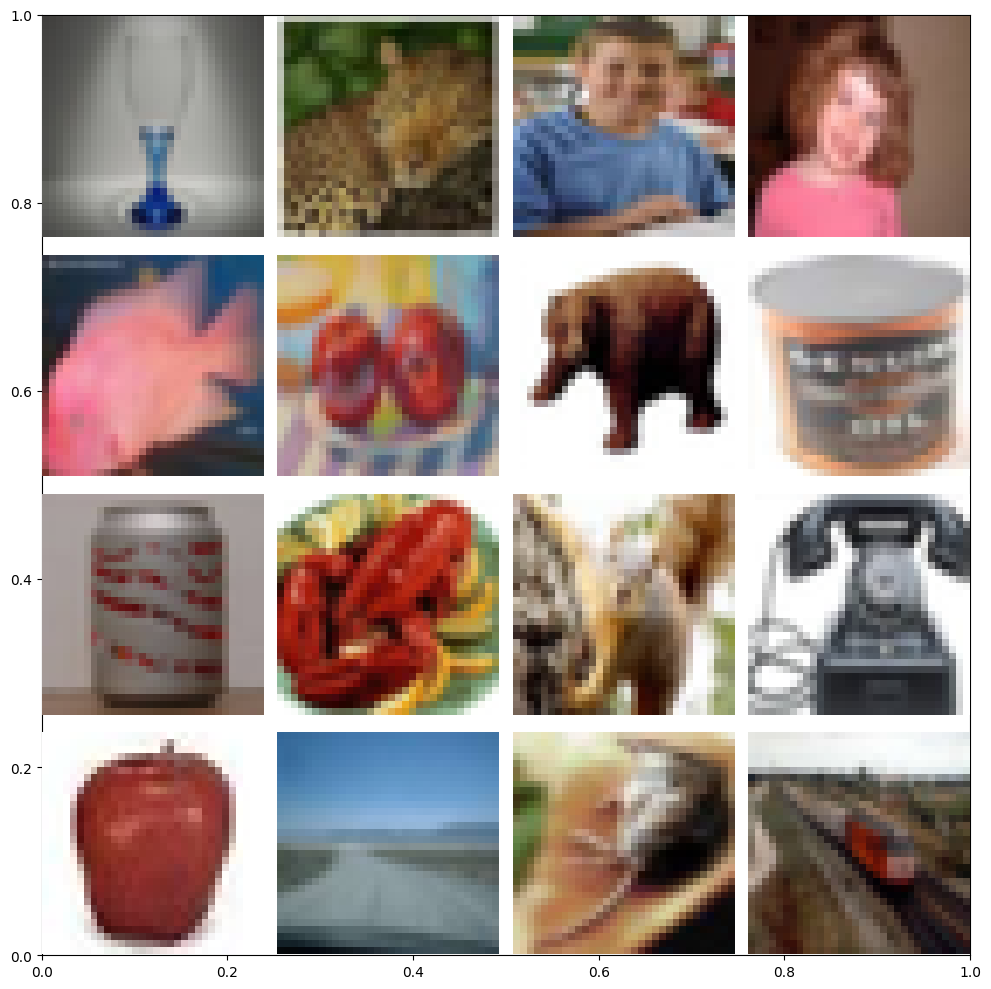

labels[25223].shape: (1,)
imgs[25223].shape: (32, 32, 3)


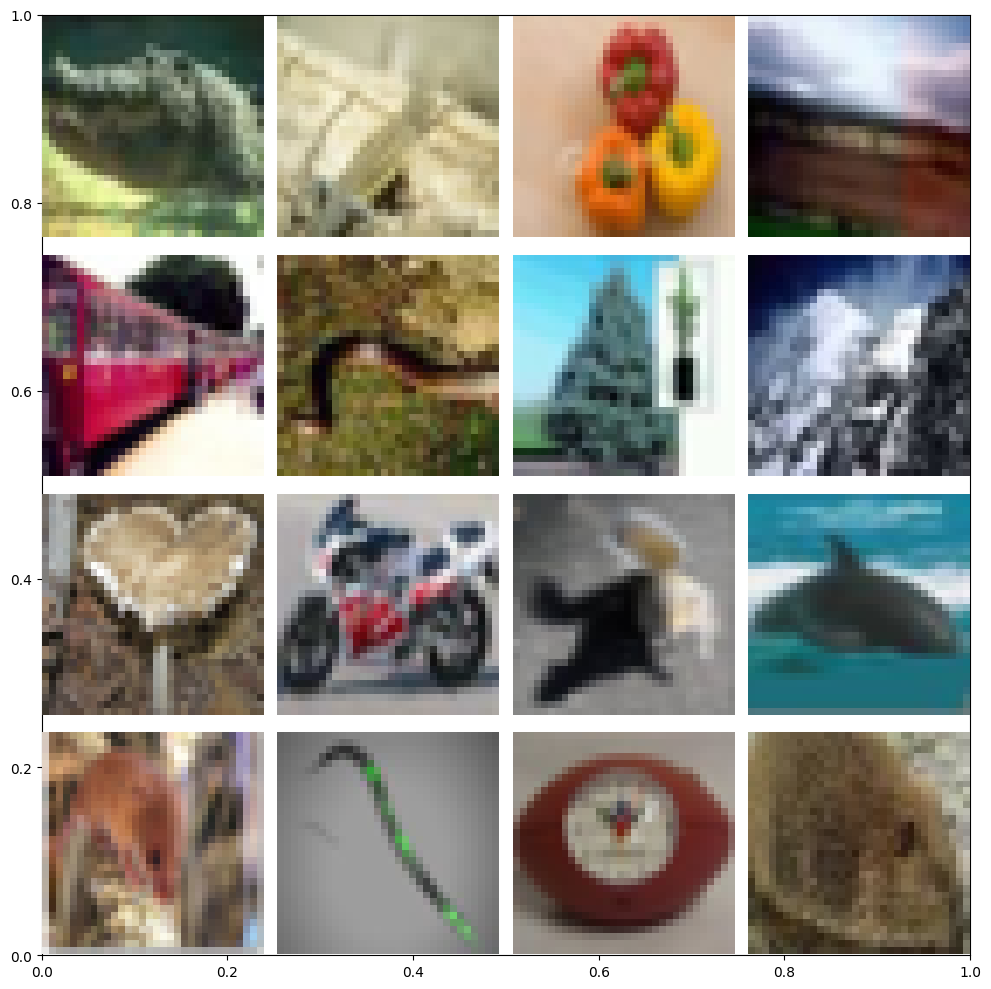

In [37]:
def display_imgs(imgs, labels):
    plt.subplots(figsize=(10,10))
    for i in range(16):
        plt.subplot(4, 4, i+1)
        k = np.random.randint(0, imgs.shape[0])
        if i == 0:
            print(f"labels[{k}].shape: {labels[k].shape}")
            print(f"imgs[{k}].shape: {imgs[k].shape}")
        plt.imshow(imgs[k])
        #plt.title(labels[k])
        plt.axis('off')
    plt.tight_layout()
    plt.show()

display_imgs(X_train, y_train)

# Normalise images (scale to range [0, 1]) - Improves convergence speed & accuracy
X_train, X_val, X_test = X_train / 255.0, X_val / 255.0, X_test / 255.0
display_imgs(X_train, y_train)

<ipython-input-38-560c59fe95b0>:18: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(labels_names, rotation=90, fontsize=15)


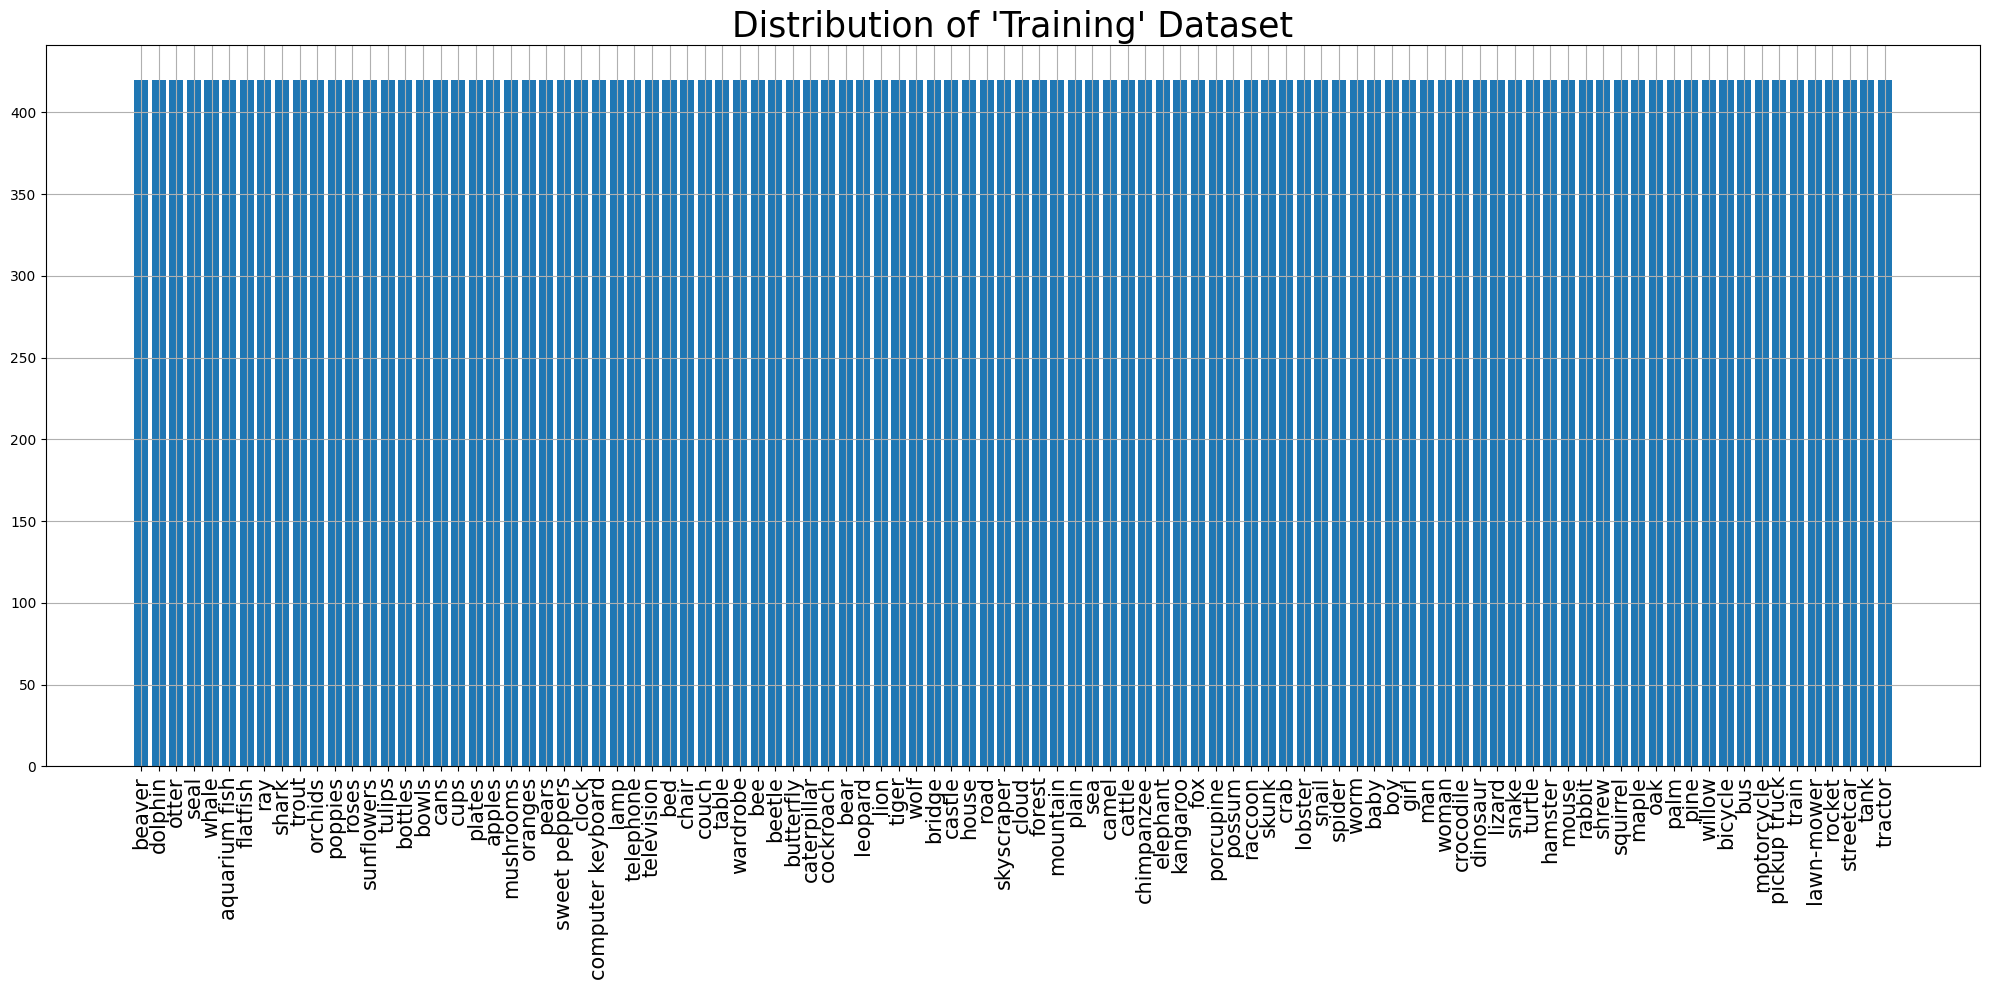

<ipython-input-38-560c59fe95b0>:18: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(labels_names, rotation=90, fontsize=15)


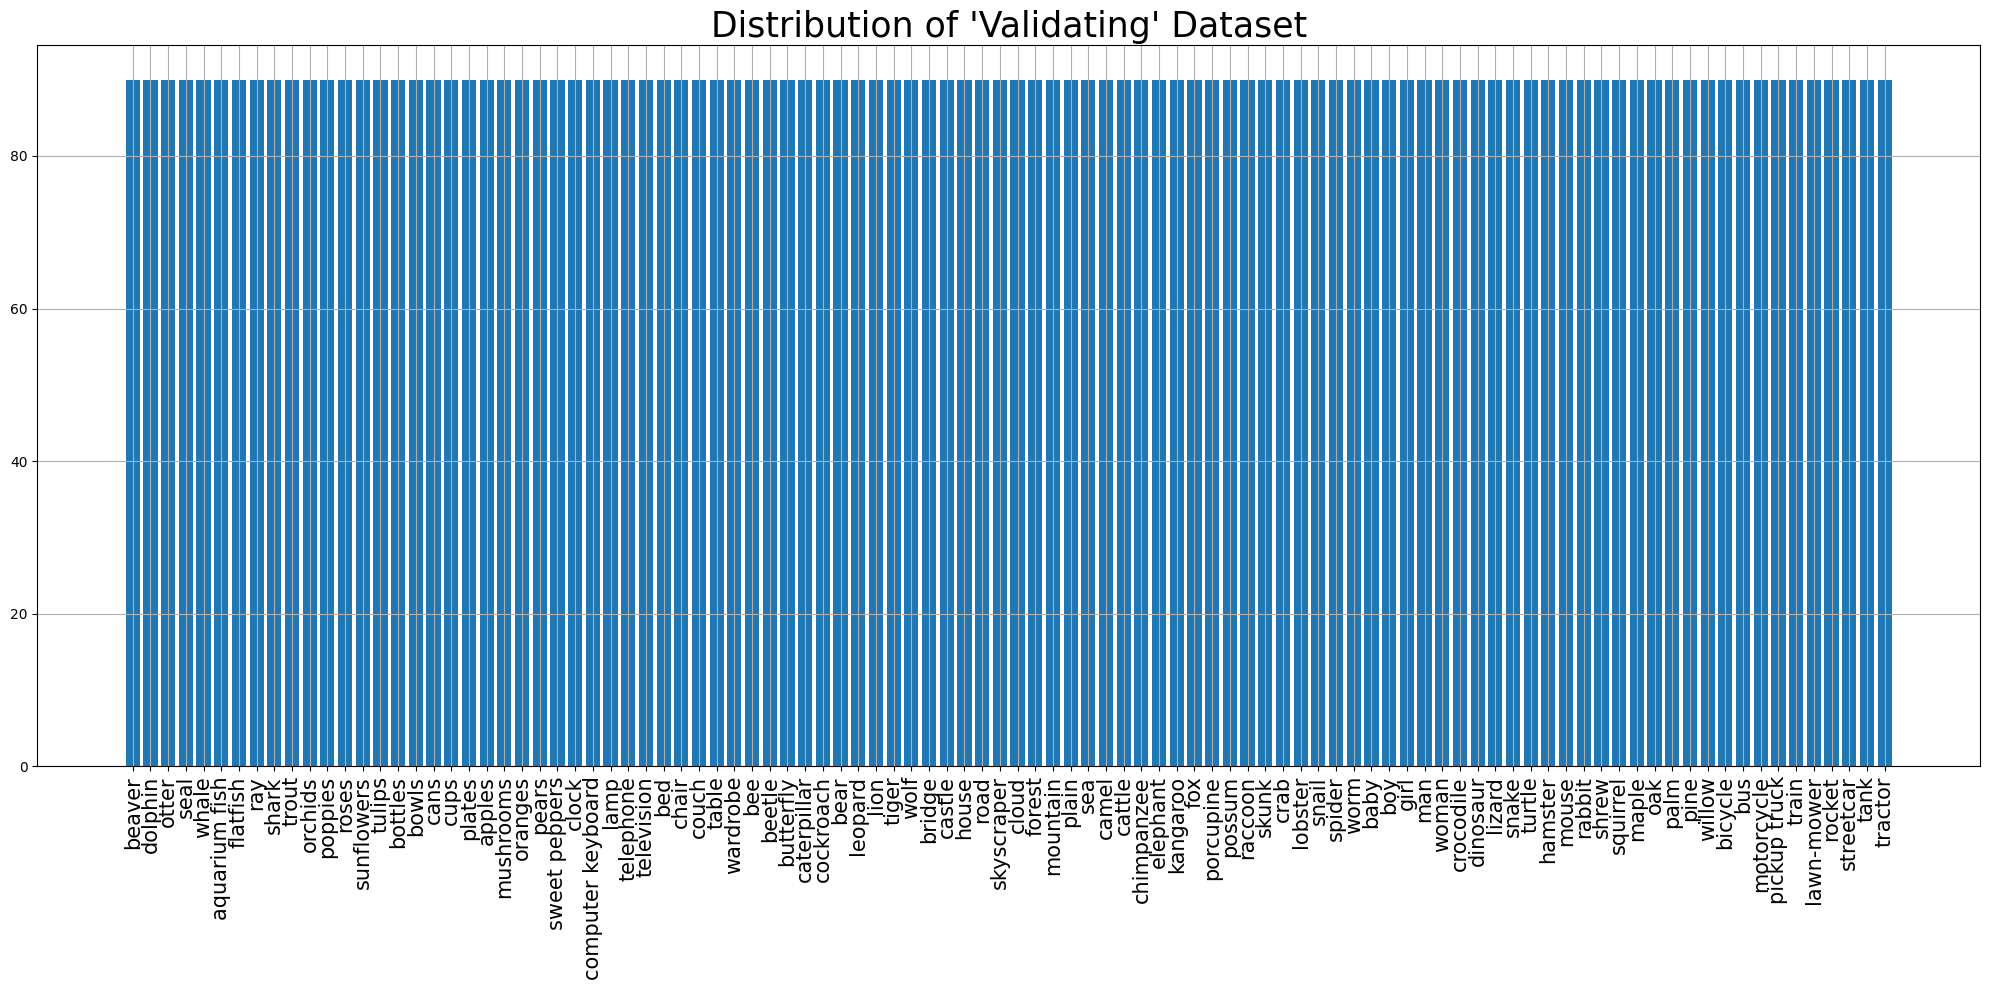

<ipython-input-38-560c59fe95b0>:18: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(labels_names, rotation=90, fontsize=15)


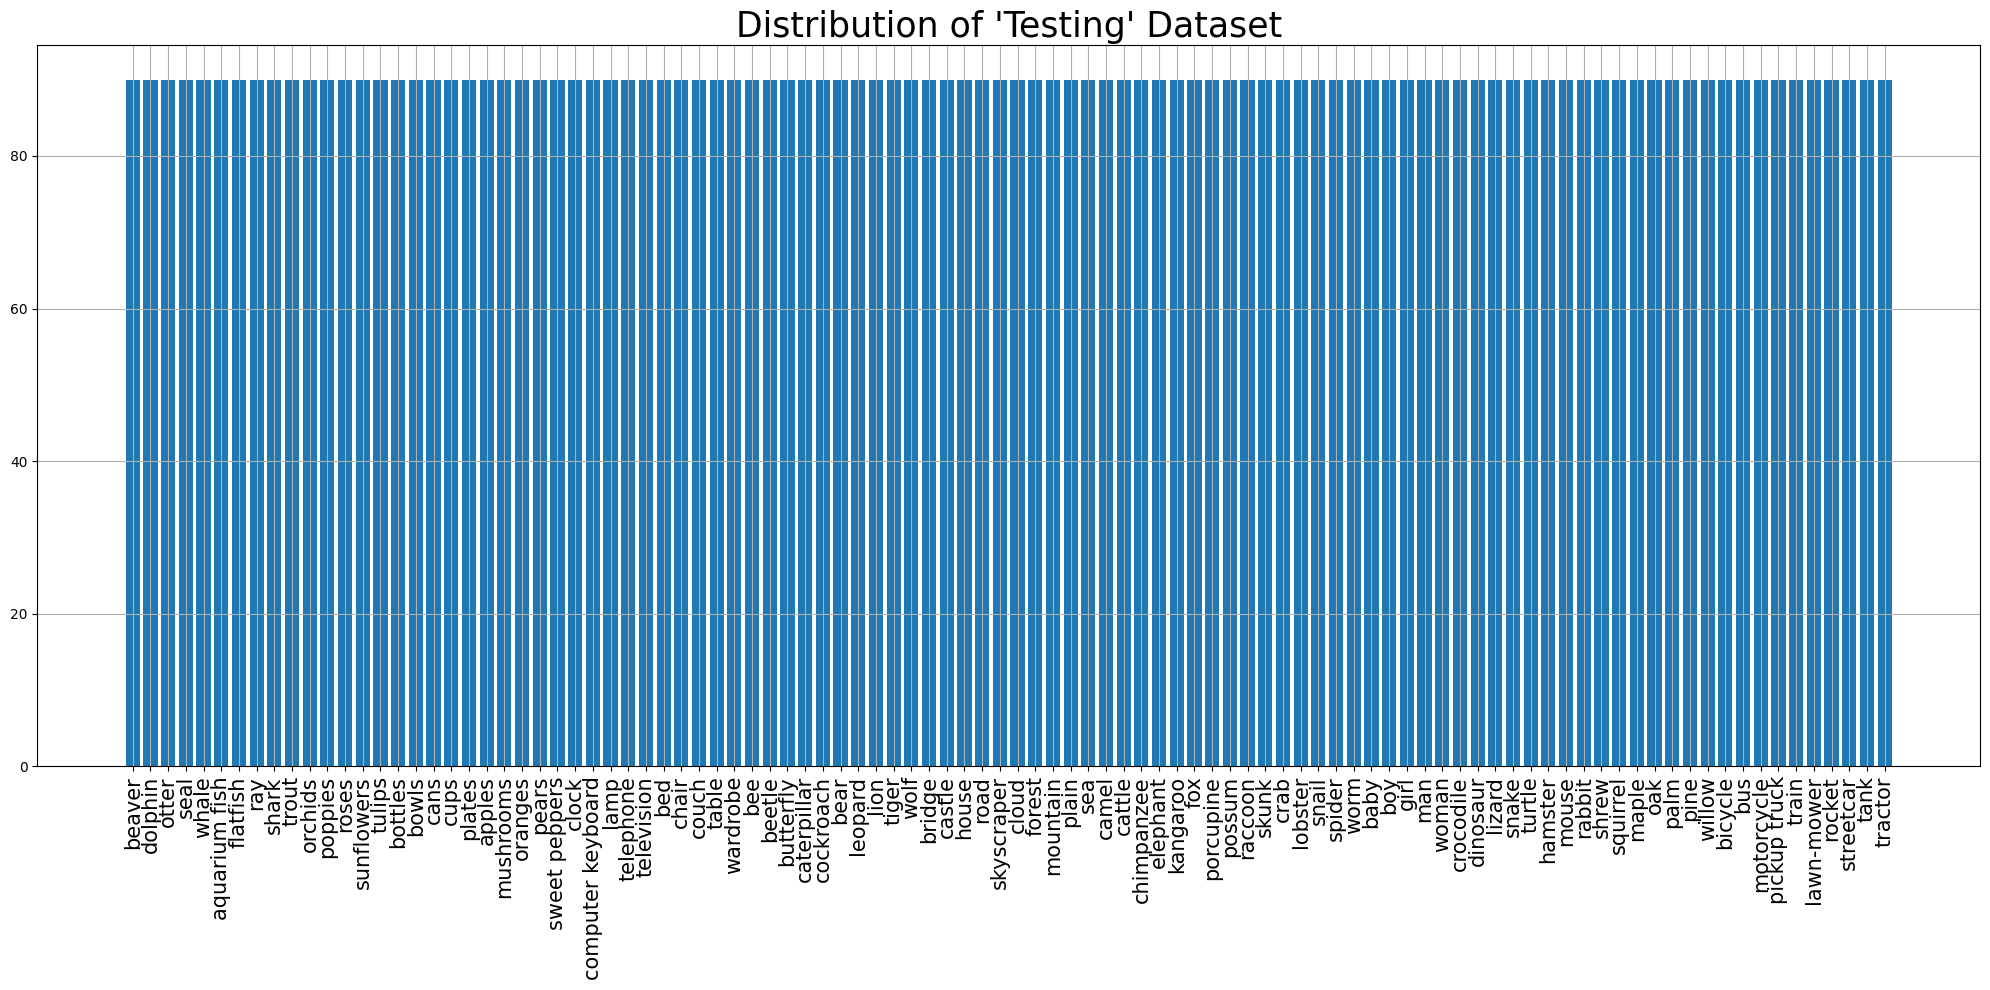

In [38]:
labels_names = ['beaver','dolphin','otter','seal','whale','aquarium fish','flatfish','ray','shark','trout',
               'orchids','poppies','roses','sunflowers','tulips','bottles','bowls','cans','cups','plates',
               'apples','mushrooms','oranges','pears','sweet peppers','clock','computer keyboard','lamp',
               'telephone','television','bed','chair','couch','table','wardrobe','bee','beetle','butterfly',
               'caterpillar','cockroach','bear','leopard','lion','tiger','wolf','bridge','castle','house',
               'road','skyscraper','cloud','forest','mountain','plain','sea','camel','cattle','chimpanzee',
               'elephant','kangaroo','fox','porcupine','possum','raccoon','skunk','crab','lobster','snail',
               'spider','worm','baby','boy','girl','man','woman','crocodile','dinosaur','lizard','snake',
               'turtle','hamster','mouse','rabbit','shrew','squirrel','maple','oak','palm','pine','willow',
               'bicycle','bus','motorcycle','pickup truck','train','lawn-mower','rocket','streetcar','tank',
               'tractor']

def class_distrib(y, labels_names, dataset_name):
    counts = pd.DataFrame(data=y).value_counts().sort_index()
    #print(f"counts:\n{counts}")
    fig, ax = plt.subplots(figsize=(20,10))
    ax.bar(labels_names, counts)
    ax.set_xticklabels(labels_names, rotation=90, fontsize=15)
    plt.title(f"Distribution of '{dataset_name}' Dataset", fontsize=25)
    plt.grid()
    plt.tight_layout()
    plt.show()
class_distrib(y_train, labels_names, "Training")
class_distrib(y_val, labels_names, "Validating")
class_distrib(y_test, labels_names, "Testing")

In [39]:
# Create TensorFlow datasets

batch_size = 64
train_dataset = (tf.data.Dataset.from_tensor_slices((X_train, y_train))
                 .map(lambda x, y: (tf.image.resize(x, (224, 224)),
                                    tf.squeeze(tf.one_hot(y, depth=100, dtype=tf.float32))))  # Remove extra dimension
                 .batch(batch_size)
                 .prefetch(tf.data.experimental.AUTOTUNE))

val_dataset = (tf.data.Dataset.from_tensor_slices((X_val, y_val))
               .map(lambda x, y: (tf.image.resize(x, (224, 224)),
                                  tf.squeeze(tf.one_hot(y, depth=100, dtype=tf.float32))))  # Remove extra dimension
               .batch(batch_size)
               .prefetch(tf.data.experimental.AUTOTUNE))

test_dataset = (tf.data.Dataset.from_tensor_slices((X_test, y_test))
                 .map(lambda x, y: (tf.image.resize(x, (224, 224)),
                                    tf.squeeze(tf.one_hot(y, depth=100, dtype=tf.float32))))  # Remove extra dimension
                .batch(batch_size)
                .prefetch(tf.data.experimental.AUTOTUNE))

print(f"Training dataset:\n {train_dataset}")
for img, lbl in train_dataset.take(1):
    #if isinstance(batch, tuple) and len(batch) == 2:
    print(f"Image shape: {img.shape}")  # Should be (batch_size, 224, 224, 3)
    print(f"Label shape: {lbl.shape}")  # Should be (batch_size, 10)
    del img,lbl
print(f"\nValidation dataset:\n {val_dataset}")
for img, lbl in val_dataset.take(1):
    #if isinstance(batch, tuple) and len(batch) == 2:
    print(f"Image shape: {img.shape}")  # Should be (batch_size, 224, 224, 3)
    print(f"Label shape: {lbl.shape}")  # Should be (batch_size, 10)
    del img,lbl
print(f"\nTesting dataset:\n {test_dataset}")
for img, lbl in test_dataset.take(1):
    #if isinstance(batch, tuple) and len(batch) == 2:
    print(f"Image shape: {img.shape}")  # Should be (batch_size, 224, 224, 3)
    print(f"Label shape: {lbl.shape}")  # Should be (batch_size, 10)
    del img,lbl

Training dataset:
 <_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 100), dtype=tf.float32, name=None))>
Image shape: (64, 224, 224, 3)
Label shape: (64, 100)

Validation dataset:
 <_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 100), dtype=tf.float32, name=None))>
Image shape: (64, 224, 224, 3)
Label shape: (64, 100)

Testing dataset:
 <_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 100), dtype=tf.float32, name=None))>
Image shape: (64, 224, 224, 3)
Label shape: (64, 100)


# Define Model

### Use pre-trained model

<class 'tuple'>
2
<class 'tensorflow.python.framework.ops.EagerTensor'> <class 'tensorflow.python.framework.ops.EagerTensor'>
(64, 224, 224, 3)
(64, 100)
Model input shape: (None, 224, 224, 3)
Model output shape: (None, 100)
2
<class 'numpy.ndarray'> <class 'numpy.ndarray'>
(64, 224, 224, 3) (64, 100)




Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ resnet50v2 (Functional)              │ (None, 7, 7, 2048)          │      23,564,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_4           │ (None, 2048)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 512)                 │       1,049,088 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 100)                 │          51,300 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 24,665,188 (94.09 MB)

 Trainable params: 1,100,388 (4.20 MB)

 Non-trainable params: 23,564,800 (89.89 MB)

Epoch 1/25
657/657 ━━━━━━━━━━━━━━━━━━━━ 38s 43ms/step - accuracy: 0.3853 - f1_score: 0.3805 - loss: 2.5337 - precision: 0.7011 - val_accuracy: 0.6030 - val_f1_score: 0.6003 - val_loss: 1.4320 - val_precision: 0.8014
Epoch 2/25
657/657 ━━━━━━━━━━━━━━━━━━━━ 18s 28ms/step - accuracy: 0.5863 - f1_score: 0.5830 - loss: 1.4537 - precision: 0.7707 - val_accuracy: 0.6181 - val_f1_score: 0.6144 - val_loss: 1.3705 - val_precision: 0.7907
Epoch 3/25
657/657 ━━━━━━━━━━━━━━━━━━━━ 18s 28ms/step - accuracy: 0.6460 - f1_score: 0.6433 - loss: 1.2323 - precision: 0.8004 - val_accuracy: 0.6261 - val_f1_score: 0.6245 - val_loss: 1.3578 - val_precision: 0.7754
Epoch 4/25
657/657 ━━━━━━━━━━━━━━━━━━━━ 18s 28ms/step - accuracy: 0.6766 - f1_score: 0.6742 - loss: 1.0957 - precision: 0.8142 - val_accuracy: 0.6290 - val_f1_score: 0.6265 - val_loss: 1.3498 - val_precision: 0.7705
Epoch 5/25
657/657 ━━━━━━━━━━━━━━━━━━━━ 18s 28ms/step - accuracy: 0.7039 - f1_score: 0.7014 - loss: 0.9759 - precision: 0.8214 - val_acc

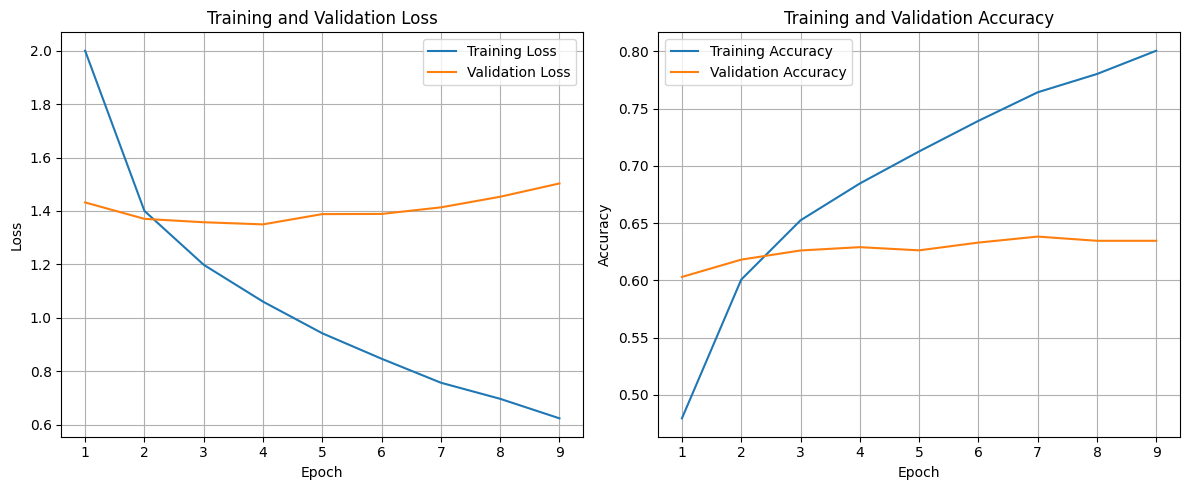

141/141 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - accuracy: 0.6163 - f1_score: 0.6079 - loss: 1.3693 - precision: 0.7522
Test Accuracy: 63.00%
Test Loss: 134.14%
Test Precision: 76.85%
Test F1 Scores (Per Class): [78.5276   78.07486  51.685387 46.249996 35.22012  68.53932  47.719296
 60.90909  84.21052  78.88888  58.59872  42.04545  62.893074 54.54545
 67.948715 58.585854 78.65168  72.47705  52.25224  55.05617  77.01864
 75.82417  78.313255 76.13636  73.41772  59.223293 49.246223 45.07042
 78.12499  58.09523  61.72839  69.047615 42.222218 54.62962  64.480865
 13.207542 69.135796 58.653843 43.165462 89.14285  69.76743  79.59184
 51.127815 72.5      47.179485 45.23809  44.534405 57.692303 80.21977
 79.775276 41.176464 72.222206 59.793808 85.2071   67.72487  42.780743
 73.99999  68.269226 70.658676 56.050945 79.787224 68.656715 62.33766
 65.       36.06557  53.59477  62.365585 58.41583  84.04254  83.5294
 68.74999  74.556206 38.55421  58.620686 34.482758 77.15736  83.07691
 55.813946 67.878784 

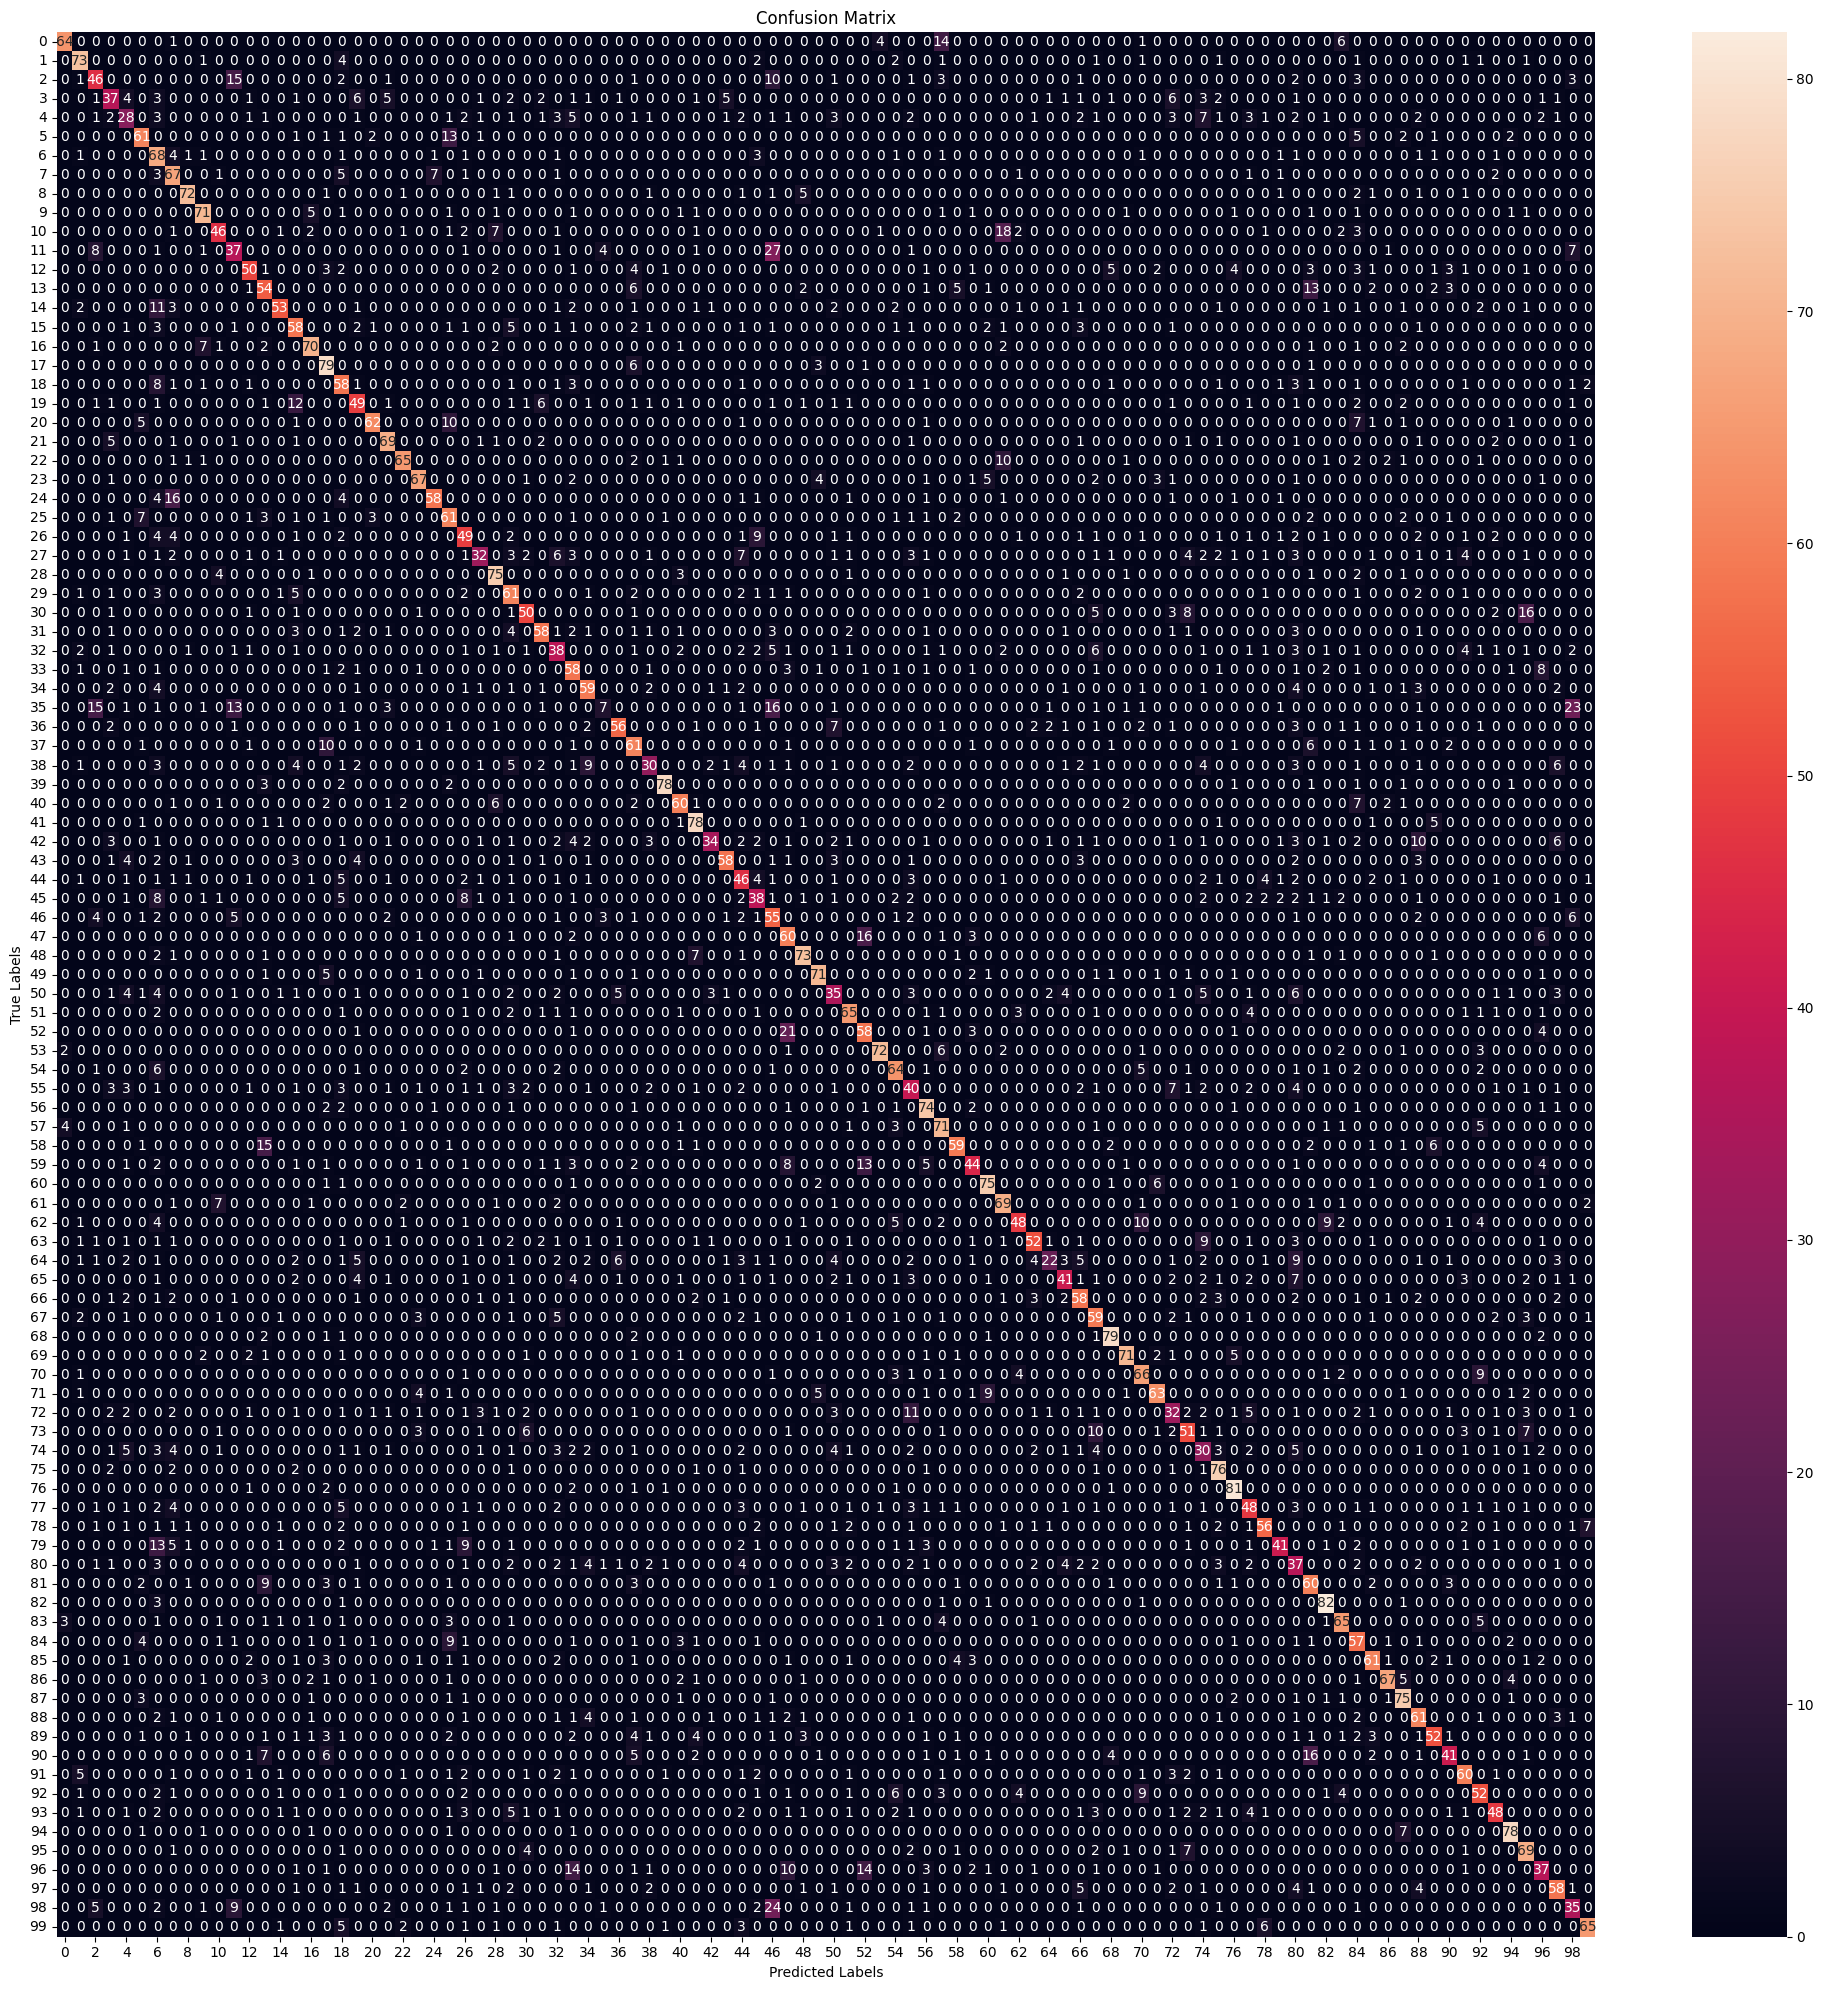

                   precision    recall  f1-score   support

           beaver       0.88      0.71      0.79        90
          dolphin       0.75      0.81      0.78        90
            otter       0.52      0.51      0.52        90
             seal       0.53      0.41      0.46        90
            whale       0.41      0.31      0.35        90
    aquarium fish       0.69      0.68      0.68        90
         flatfish       0.35      0.76      0.48        90
              ray       0.52      0.74      0.61        90
            shark       0.89      0.80      0.84        90
            trout       0.79      0.79      0.79        90
          orchids       0.69      0.51      0.59        90
          poppies       0.43      0.41      0.42        90
            roses       0.72      0.56      0.63        90
       sunflowers       0.50      0.60      0.55        90
           tulips       0.80      0.59      0.68        90
          bottles       0.54      0.64      0.59       

,accuracy,f1_score,loss,precision,val_accuracy,val_f1_score,val_loss,val_precision,epoch
0,0.479595,"(tf.Tensor(0.7199046, shape=(), dtype=float32)...",2.000295,0.735343,0.603000,"(tf.Tensor(0.71232873, shape=(), dtype=float32...",1.431989,0.801353,0
1,0.600690,"(tf.Tensor(0.7826086, shape=(), dtype=float32)...",1.400343,0.777302,0.618111,"(tf.Tensor(0.78527606, shape=(), dtype=float32...",1.370537,0.790661,1
2,0.652429,"(tf.Tensor(0.8191616, shape=(), dtype=float32)...",1.198522,0.804520,0.626111,"(tf.Tensor(0.81481475, shape=(), dtype=float32...",1.357803,0.775437,2
3,0.684571,"(tf.Tensor(0.846975, shape=(), dtype=float32),...",1.060500,0.818517,0.629000,"(tf.Tensor(0.80239516, shape=(), dtype=float32...",1.349845,0.770451,3
4,0.712548,"(tf.Tensor(0.855436, shape=(), dtype=float32),...",0.941934,0.828618,0.626222,"(tf.Tensor(0.74999994, shape=(), dtype=float32...",1.388317,0.753188,4
5,0.739238,"(tf.Tensor(0.8554502, shape=(), dtype=float32)...",0.846573,0.843282,0.633000,"(tf.Tensor(0.80459756, shape=(), dtype=float32...",1.388954,0.751363,5
6,0.764167,"(tf.Tensor(0.88207537, shape=(), dtype=float32...",0.756771,0.854223,0.638222,"(tf.Tensor(0.7909604, shape=(), dtype=float32)...",1.413538,0.748072,6
7,0.780143,"(tf.Tensor(0.8939213, shape=(), dtype=float32)...",0.696428,0.861287,0.634556,"(tf.Tensor(0.7909604, shape=(), dtype=float32)...",1.453343,0.733744,7
8,0.800452,"(tf.Tensor(0.8959811, shape=(), dtype=float32)...",0.623352,0.871435,0.634556,"(tf.Tensor(0.80898875, shape=(), dtype=float32...",1.503118,0.726431,8


In [72]:
#### Set up model
# Load ResNet50 pre-trained on ImageNet (w/out the top classification layer which is designed for ImageNet (diff dataset))
resnet_50_base = tf.keras.applications.ResNet50V2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the layers of VGG16 so they don't get updated during training - can unfreeze for fine tuning later
resnet_50_base.trainable = False

# Add custom classification layers for CIFAR-100 (100 classes) - adapt model to CIFAR-100
model = models.Sequential([
    resnet_50_base,
    layers.GlobalAveragePooling2D(), # Better for ResNet than Flatten
    layers.Dense(512, activation='relu'),
    layers.Dropout(0.4),
    layers.Dense(100, activation='softmax')  # CIFAR-100 has 100 classes
])

for sample in test_dataset.take(1):
    print(type(sample))  # Should be <class 'tuple'>
    print(len(sample))  # Should be 2
    print(type(sample[0]), type(sample[1]))  # Both should be <class 'tensorflow.Tensor'>
    print(sample[0].shape)  # Should be (batch_size, 224, 224, 3)
    print(sample[1].shape)  # Should be (batch_size, 100)
print(f"Model input shape: {model.input_shape}")
print(f"Model output shape: {model.output_shape}")
sample = next(iter(test_dataset.as_numpy_iterator()))
print(len(sample))  # Should be 2
print(type(sample[0]), type(sample[1]))  # Both should be <class 'numpy.ndarray'>
print(sample[0].shape, sample[1].shape)  # Should match model input and output
print("\n")
#for x, y in test_dataset.take(1):
#    print(type(x), type(y))  # Both should be <class 'tensorflow.Tensor'>
#for x_batch, y_batch in test_dataset.take(1):
#    test_loss, test_acc = model.evaluate(x_batch, y_batch)
#    print(f"Test Loss: {test_loss}, Test Accuracy: {test_acc}")

# Compile the model
#tensorboard_callback = keras.callbacks.TensorBoard(log_dir="./logs")
model.compile(optimizer=optimizers.Adam(learning_rate=1e-3),
              loss='categorical_crossentropy',
              metrics=['accuracy', 'precision', 'f1_score'])

model.summary()

#### Train Model & Track Training/Validation Error
early_stopping = EarlyStopping(monitor='val_loss', # or val_accuracy
                               patience=5, # Num. epochs with no improvements - help void overfitting
                               restore_best_weights=True)
#reduce_lr = ReduceLROnPlateau(monitor='val_loss', # or val_accuracy
#                              factor=0.1, # Reduce lr by a factor
#                              patience=3, # Num epochs w/ no improvement
#                              min_lr=1e-6, # Min lr
#                              verbose=1)
#tensorboard = TensorBoard(log_dir='./logs', # Logs directory
#                         histogram_freq=1, # Logs histograms for weights/activations
#                         write_graph=True, # Logs graph of model
#                         write_images=True) # Log images like weight histogram
#checkpoint = ModelCheckpoint('best_model.h5',
#                             monitor='val_loss', # or val_accuracy
#                             save_best_only=True, # Save only best model
#                             mode='min', # min for loss or max for accuracy
#                             verbose=1)
#cvs_logger = CSVLogger('training_log.csv', seperator=',', append=True) # Save train metrics to analyse

# Train the model
history = model.fit(train_dataset, validation_data=val_dataset, epochs=25,
                    batch_size=batch_size, callbacks=[early_stopping], verbose=1)

#### Plot Training & Validation Error

# Extract loss and accuracy
epochs = range(1,len(history.history['loss'])+1)
train_loss = history.history['loss']
val_loss = history.history['val_loss']
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

def plot_evidence(epochs, train_loss, val_loss, train_acc, val_acc):
    # Plot Training and Validation Loss
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_loss, label='Training Loss')
    plt.plot(epochs, val_loss, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.grid()

    # Plot Training and Validation Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_acc, label='Training Accuracy')
    plt.plot(epochs, val_acc, label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.legend()
    plt.grid()

    plt.tight_layout()
    plt.show()

plot_evidence(epochs, train_loss, val_loss, train_acc, val_acc)

#### Evaluate Model on Test Data

# Evaluate on test data
results = model.evaluate(test_dataset)
test_loss = results[0]
test_acc = results[1]
test_precision = results[2]
test_f1_scores = results[3]
print(f"Test Accuracy: {test_acc*100:.2f}%")
print(f"Test Loss: {test_loss*100:.2f}%")
print(f"Test Precision: {test_precision*100:.2f}%")
print(f"Test F1 Scores (Per Class): {test_f1_scores.numpy()*100}")
print(f"Average Test F1 Scores:{np.average(test_f1_scores.numpy()*100):.2f}\n")

#### Generate Confusion Matrix

# Get predictions
X_test_revised = tf.image.resize(X_test, (224, 224))
y_pred = model.predict(X_test_revised)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = y_test.flatten()

# Compute confusion matrix
conf_matrix = confusion_matrix(y_true_classes, y_pred_classes)

# Plot confusion matrix
plt.figure(figsize=(20, 20))
sns.heatmap(conf_matrix, annot=True) #cmap='Blues', fmt='d'
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.tight_layout()
plt.show()

print(classification_report(y_true_classes, y_pred_classes, target_names=labels_names))
#tensorboard --logdir==path_to_your_logs

# Create a DataFrame from the history of the training and store the epoch values.
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch

# Finally, display the hist DataFrame.
hist

### Fine-tune model

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ resnet50v2 (Functional)              │ (None, 7, 7, 2048)          │      23,564,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_4           │ (None, 2048)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 512)                 │       1,049,088 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 100)                 │          51,300 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 24,665,188 (94.09 MB)

 Trainable params: 4,516,452 (17.23 MB)

 Non-trainable params: 20,148,736 (76.86 MB)

Epoch 1/15
657/657 ━━━━━━━━━━━━━━━━━━━━ 45s 46ms/step - accuracy: 0.6566 - loss: 1.1952 - val_accuracy: 0.6451 - val_loss: 1.3098
Epoch 2/15
657/657 ━━━━━━━━━━━━━━━━━━━━ 19s 29ms/step - accuracy: 0.7252 - loss: 0.9184 - val_accuracy: 0.6551 - val_loss: 1.2875
Epoch 3/15
657/657 ━━━━━━━━━━━━━━━━━━━━ 19s 29ms/step - accuracy: 0.7505 - loss: 0.8336 - val_accuracy: 0.6577 - val_loss: 1.2748
Epoch 4/15
657/657 ━━━━━━━━━━━━━━━━━━━━ 19s 29ms/step - accuracy: 0.7651 - loss: 0.7675 - val_accuracy: 0.6610 - val_loss: 1.2675
Epoch 5/15
657/657 ━━━━━━━━━━━━━━━━━━━━ 19s 29ms/step - accuracy: 0.7853 - loss: 0.7101 - val_accuracy: 0.6639 - val_loss: 1.2622
Epoch 6/15
657/657 ━━━━━━━━━━━━━━━━━━━━ 19s 29ms/step - accuracy: 0.7982 - loss: 0.6624 - val_accuracy: 0.6662 - val_loss: 1.2585
Epoch 7/15
657/657 ━━━━━━━━━━━━━━━━━━━━ 19s 29ms/step - accuracy: 0.8124 - loss: 0.6212 - val_accuracy: 0.6677 - val_loss: 1.2580
Epoch 8/15
657/657 ━━━━━━━━━━━━━━━━━━━━ 19s 29ms/step - accuracy: 0.8224 - loss: 0.5868 - 

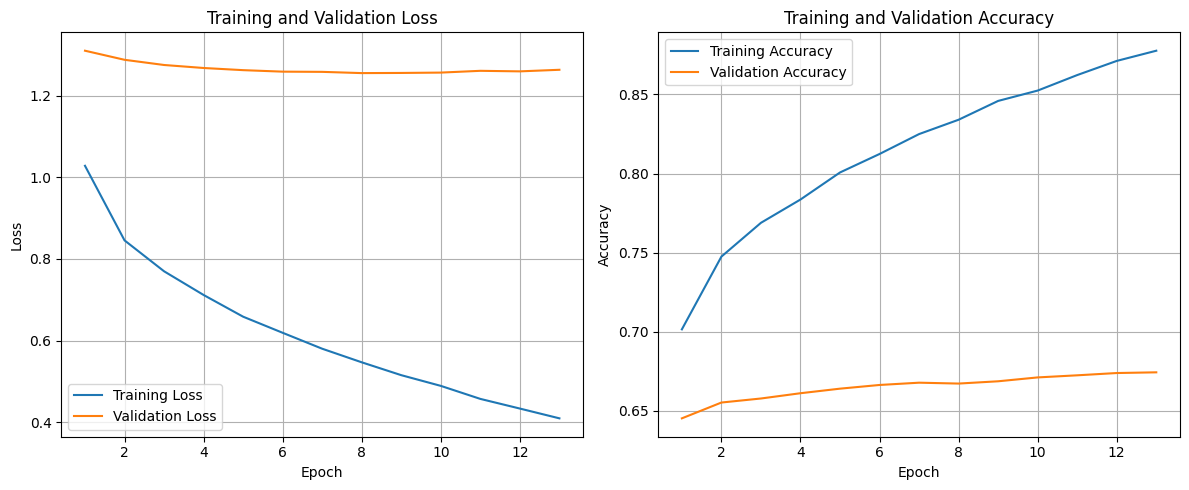

141/141 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - accuracy: 0.6616 - loss: 1.2561
Test Accuracy: 67.28%
282/282 ━━━━━━━━━━━━━━━━━━━━ 11s 27ms/step


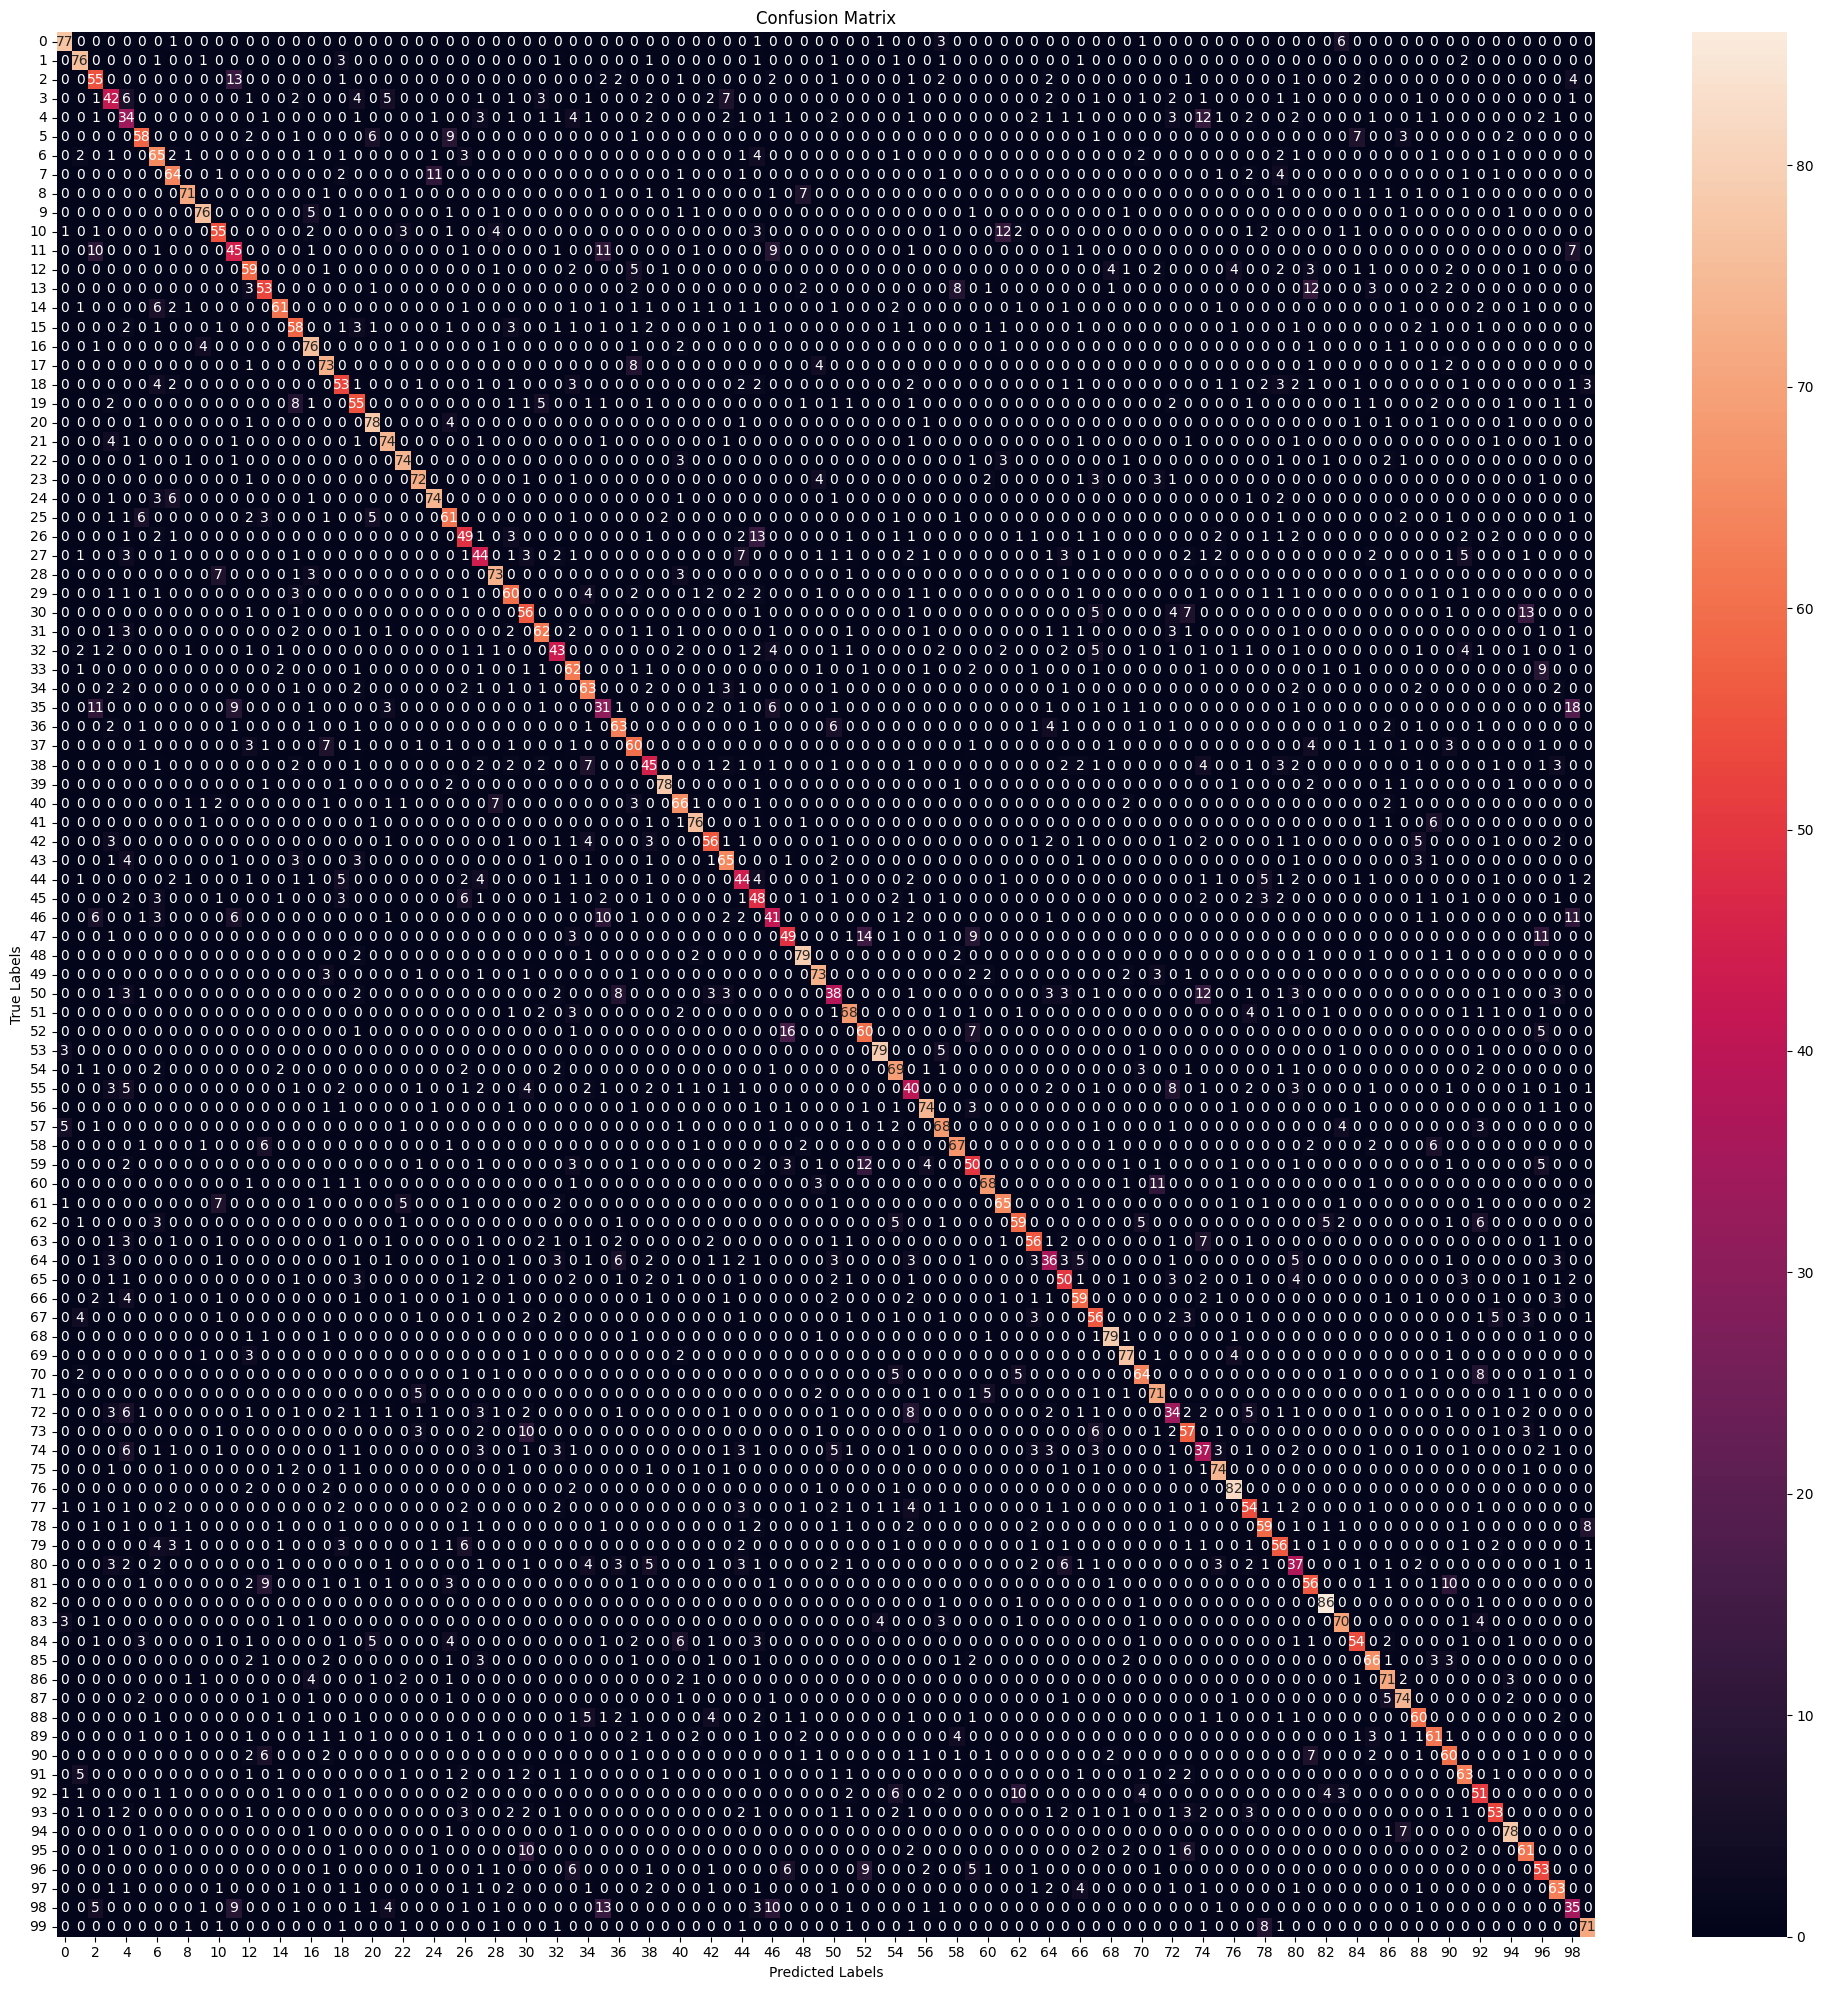

                   precision    recall  f1-score   support

           beaver       0.84      0.86      0.85        90
          dolphin       0.77      0.84      0.80        90
            otter       0.54      0.61      0.58        90
             seal       0.50      0.47      0.48        90
            whale       0.35      0.38      0.36        90
    aquarium fish       0.72      0.64      0.68        90
         flatfish       0.62      0.72      0.67        90
              ray       0.69      0.71      0.70        90
            shark       0.87      0.79      0.83        90
            trout       0.87      0.84      0.86        90
          orchids       0.66      0.61      0.64        90
          poppies       0.52      0.50      0.51        90
            roses       0.63      0.66      0.64        90
       sunflowers       0.64      0.59      0.61        90
           tulips       0.81      0.68      0.74        90
          bottles       0.64      0.64      0.64       

,accuracy,loss,val_accuracy,val_loss,epoch
0,0.701405,1.028026,0.645111,1.309778,0
1,0.747429,0.845443,0.655111,1.287548,1
2,0.768809,0.769791,0.657667,1.274828,2
3,0.783548,0.711781,0.661000,1.267476,3
4,0.800667,0.658605,0.663889,1.262181,4
5,0.812357,0.619180,0.666222,1.258533,5
6,0.824952,0.580194,0.667667,1.258013,6
7,0.834024,0.546936,0.667111,1.254979,7
8,0.845929,0.515449,0.668556,1.255354,8
9,0.852476,0.489242,0.671000,1.256219,9


In [74]:
#### Adapt model
# Unfreeze last 10 layers
for layer in resnet_50_base.layers[-10:]:
    layer.trainable = True # Allow layers to be updated

# Compile again w/ lower learning rate (prevents destroying learned features)
model.compile(optimizer=optimizers.Adam(learning_rate=1e-5),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

#### Modify datasets
def augment_dataset(x, y):
    x = tf.image.resize(x, (224, 224))  # Resize images
    x = tf.image.random_flip_left_right(x)  # Random horizontal flip
    x = tf.image.random_brightness(x, max_delta=0.2)  # Adjust brightness
    x = tf.image.random_contrast(x, lower=0.8, upper=1.2)  # Adjust contrast
    y = tf.squeeze(tf.one_hot(y, depth=100, dtype=tf.float32))  # One-hot encode labels
    return x, y
train_dataset_aug = (tf.data.Dataset.from_tensor_slices((X_train, y_train))
                 .map(augment_dataset, num_parallel_calls=tf.data.experimental.AUTOTUNE)
                 .batch(batch_size)
                 .prefetch(tf.data.experimental.AUTOTUNE))
# Not val or test as augment train helps generalise better, but want to provide consistent benchmark for eval perf

#### Train Model & Track Training/Validation Error

# Train the model
history_fine_tune = model.fit(train_dataset, validation_data=val_dataset, epochs=15,
                              batch_size=batch_size, callbacks=[early_stopping], verbose=1)

#### Plot Training & Validation Error

# Extract loss and accuracy
epochs = range(1,len(history_fine_tune.history['loss'])+1)
train_loss = history_fine_tune.history['loss']
val_loss = history_fine_tune.history['val_loss']
train_acc = history_fine_tune.history['accuracy']
val_acc = history_fine_tune.history['val_accuracy']

plot_evidence(epochs, train_loss, val_loss, train_acc, val_acc)

#### Evaluate Model on Test Data

# Evaluate on test data
test_loss, test_acc = model.evaluate(test_dataset)
print(f"Test Accuracy: {test_acc*100:.2f}%")

#### Generate Confusion Matrix

# Get predictions
X_test_revised = tf.image.resize(X_test, (224, 224))
y_pred = model.predict(X_test_revised)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = y_test.flatten()

# Compute confusion matrix
conf_matrix = confusion_matrix(y_true_classes, y_pred_classes)

# Plot confusion matrix
plt.figure(figsize=(20, 20))
sns.heatmap(conf_matrix, annot=True) #cmap='Blues', fmt='d'
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.tight_layout()
plt.show()

print(classification_report(y_true_classes, y_pred_classes, target_names=labels_names))

# Create a DataFrame from the history of the training and store the epoch values.
hist = pd.DataFrame(history_fine_tune.history)
hist['epoch'] = history_fine_tune.epoch

# Finally, display the hist DataFrame.
hist